# Survey Data Analysis for Koch

Evaluator, thank you for taking the time to review my report.  This document is written in an informal voice and includes in-line code to facillitate evaluation.  In an actual report to non-technical stakeholders, the code would be separated from the reader with only tables, graphs, and visualizations to summarize the data, and occasional confidence intervals and references for the more technically inclined.

All descriptions of the code are placed in the section headers.  Comments within the code provide further explanation and references, when appropriate.

__Included deliverables__

* Description of process and methods, including your code
* Summary of model performance measures
* Visualizations for communicating results
* A scored file (.csv) with i) probabilities and ii) classifications.

Files submitted
* demo_Report-Koch.ipynb / .html
* demo_Report-Predict_Koch.ipynb / .html
* results.csv

<br>
<br>
<br>
<br>
<hr>

# Report Analysis

<br>

__Executive Summary__

This report outlines the i) modeling of completed survey and profile data, and the ii) prediction of survey response data from the provided profile data.  The results of the predictions are programmed in the 'Predict_Koch' report and provided in the 'class_predict.txt', 'class_prob.txt' files.  These results come with modest confidence because the trained K-Nearest Neighbors model performed at an average test accuracy level, ~67% (AUC 0.74).  Future work to improve accuracy could include combining the trained models as an ensemble routine, as well as creating more transformed features.  The report explains the steps taken to reach these conclusions, as well as the initial data quality checks and analysis that support the methodology.

<br>

__Problem__

Predict whether a voter is likely to support higher government spending versus reducing the national debt when given a choice.

__Evaluation__

Classifiers are primarily trained to maximize Accuracy score and are evaluated by this measure with test data.  Secondary interest is in maintaining overall model integrity and quality through standard modeling practices, and by comparing the area under the curve (AUC) and the ROC curve, directly.  Neither an error by False Positive or False Negative hold priority; however, there should not be an extereme difference between the two.

__Process__

The report and analysis move in a linear fashion reflecting the predictive modeling process.  After loading the training data, copious checks are performed to ensure quality and that no glaring anomalies exist.  Before the training - testing data split, the data are _balanced_ by resampling from the negative response data until it has the same count as the positive response.  Balancing the data allows for accuracy to be used as a measure of evaluation more effectively, across different modeling approaches, and makes use of all available data (as opposed to decreasing the number of positive responses).

Once these basic considerations are complete, an exploratory data analysis is made into the numeric and categoric data, separately.  Data appear to have some strong assocations across features, but also fail to neatly discrimate the response data.  This leads to the choice of Principle Components Analysis (PCA) to be the main driver of dimensionality reduction.  PCA, encoding, and other transformations support the data pipeline before modeling.

Three model families are trained, each with different characteristics.  K-Nearest Neighbors (accuracy: 67%, AUC: 0.74) is the most simple.  Logistic Regression (accuracy: 60%, AUC: 0.62) is used as a traditional approach to binary response data.  Random Forest (accuracy: 63%, AUC: 0.673) is more sophisticated in implementation and complex in structure.  These models are trained using K-folds Cross Validation, with hyper-parameter tunning using grid search for Logistic Regression and Random Forest models, and stochastic search for K-Nearest Neighbors.

K-Nearest Neighbors performs the best when accuracy is obtained from test data.  It is mostly balanced in its False Positive and False Negative errors.  It also dominates the other models in the  Receiver Operating Characteristic curve and Area Under Curve (AUC).


__Prediction Implementation and Future Work__

The model is implemented in the 'demo_Report-Predict_Koch.ipynb' file.  With more time I would add all models to an ensemble routine.  I would also add customized pre-processing to the model's current pipeline so that it would be more self-contained.

<br>
<br>
<hr>

Data files provided
* File 1: Survey responses – 20,000 records
* File 2: Available features – 20,000 records
* File 3: Submission file – 29,231 records

In [1]:
import numpy as np
import pandas as pd

np.__version__, pd.__version__

('1.15.4', '0.23.4')

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 50)

In [5]:
!ls Data/survey

DS_Role_Project_Instructions_Spending_2016.docx  File2.csv  Predict
DS_Role_Project_Instructions_Spending_2016.odt	 File3.csv  ProjectFiles.zip
File1.csv					 Models


In [6]:
! head Data/survey/File1.csv

﻿ID,State,SPENDINGRESPONSE
18138,AK,Spend to Improve Economy
25537,AK,Spend to Improve Economy
27167,AK,Reduce National Debt and Deficit
31853,AK,Reduce National Debt and Deficit
67467,AK,Reduce National Debt and Deficit
76622,AK,Reduce National Debt and Deficit
84724,AK,Reduce National Debt and Deficit
105767,AK,Spend to Improve Economy
118550,AK,Reduce National Debt and Deficit


<br>
<br>

# Load and Validate Data

The data from File1 and File2 appear to merge without any problems.  The code below performs validations to check that there are no obvious mistakes between the files and ensures correct data types.

Note that the dataset is unbalanced in that nearly twice as many responsdents answered to reduce government spending, as opposed to spend to improve.  This is neutralized by sampling with replacement from the negative group so that the number of groups are the same.  

In [7]:
file1 = pd.read_csv("Data/survey/File1.csv", header="infer", index_col=False)
print(file1.shape)
file1.head(3)

(20000, 3)


,ID,State,SPENDINGRESPONSE
0,18138,AK,Spend to Improve Economy
1,25537,AK,Spend to Improve Economy
2,27167,AK,Reduce National Debt and Deficit


In [8]:
file2 = pd.read_csv("Data/survey/File2.csv")
print(file2.shape)
file2.head()

(20000, 149)


,ID,State,f1,f2,f3,f4,f5,f6,f7,f8,...,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147
0,18138,AK,AK01,63,E,61.0,55.33333,66.0,52.33333,49.25,...,9.0,4.0,4.0,6.0,9.0,6.0,3.0,0.0,3.0,NaN
1,25537,AK,AK01,55,E,61.0,55.33333,66.0,52.33333,49.25,...,9.0,7.0,8.0,8.0,4.0,6.0,8.0,4.0,4.0,NaN
2,27167,AK,AK01,49,D,61.0,55.33333,66.0,52.33333,49.25,...,9.0,8.0,7.0,6.0,8.0,8.0,9.0,3.0,6.0,NaN
3,31853,AK,AK01,67,D,61.0,55.33333,66.0,52.33333,49.25,...,7.0,9.0,5.0,9.0,4.0,7.0,7.0,4.0,4.0,NaN
4,67467,AK,AK01,58,M,61.0,55.33333,66.0,52.33333,49.25,...,5.0,1.0,7.0,8.0,9.0,3.0,4.0,3.0,1.0,NaN


In [9]:
# check on state
Survey = file1.merge(file2, left_on="ID", right_on="ID", how="left")
chk1 = Survey
print(chk1.shape)
(chk1.loc[chk1.State_x != chk1.State_y,]).shape[0] == 0

(20000, 151)


True

In [10]:
lvl_reduce = Survey.SPENDINGRESPONSE.value_counts().index[0]
Survey["resp"] = 0
Survey.loc[Survey.SPENDINGRESPONSE == lvl_reduce, ["resp"]] = 1
Survey.resp.value_counts()

1    13831
0     6169
Name: resp, dtype: int64

__Neutral Dataset__

Currently, the data are highly unbalanced in that there are more than twice as many of one response as the other.  This can be a dangerous situation that skews how models train and the results they provide.  We will neutralize this dataset by sampling with replacement from the smaller response group.

In [11]:
LessGov = Survey.loc[Survey.resp==1,]
MoreGov = Survey.loc[Survey.resp==0,].sample(n=13831, replace=True, random_state=1)
Survey = pd.concat([LessGov, MoreGov]).reset_index(drop=True)
print( Survey.shape[0] == (LessGov.shape[0]+13831) )
print( Survey.shape)

True
(27662, 152)


__Check Response__

In [12]:
# create y_tng
#note: unbalanced dataset
chk1 = Survey
chk1.resp.value_counts()

1    13831
0    13831
Name: resp, dtype: int64

In [13]:
#top supporters - seems plausible
chk2 = pd.crosstab(chk1.State_x, chk1.resp, margins=True)
chk2
chk2["prop"] = chk2[1]/chk2["All"]
chk3 = chk2.sort_values(["prop"], ascending=False)
chk3.head()

resp,0,1,All,prop
State_x,,,,
MT,39,89,128,0.695312
UT,155,297,452,0.657080
NE,94,165,259,0.637066
ID,88,143,231,0.619048
ND,23,37,60,0.616667


In [14]:
y_set = Survey.resp

__Check Features__

In [15]:
feat = Survey.drop(columns=["ID","State_x","SPENDINGRESPONSE"])
feat.rename(columns = {'State_y':'State'}, inplace = True)

In [16]:
(feat.dtypes).value_counts()

float64    121
object      24
int64        4
dtype: int64

In [17]:
feat.loc[:, feat.dtypes == np.int64].head()
#feat.f2.describe()    #[18-104]:assume numeric => age
#feat.f93.value_counts()    #[0-4]:assume categorical
#feat.f94.value_counts()    #[0-4]:assume categorical

,f2,f93,f94,resp
0,49,4,1,1
1,67,4,2,1
2,58,4,4,1
3,70,4,3,1
4,66,4,3,1


In [18]:
(feat.loc[:, feat.dtypes == np.object]).head()

,State,f1,f3,f12,f13,f95,f96,f97,f98,f99,...,f108,f110,f114,f115,f118,f119,f120,f121,f122,f126
0,AK,AK01,D,A,A,F,A,J,A,J,...,C,T,G,DE,G,N,P,EN,NaN,J
1,AK,AK01,D,E,A,F,A,A,A,J,...,D,R,I,NaN,G,NaN,NaN,NaN,NaN,NaN
2,AK,AK01,M,A,B,F,A,A,A,A,...,E,S,N,E5,G,R,P,EN,NaN,E
3,AK,AK01,E,A,A,F,B,A,A,J,...,B,Z,L,DE,G,D,P,EN,NaN,NaN
4,AK,AK01,P,A,A,F,A,A,A,A,...,H,K,K,DE,G,N,P,EN,NaN,H


In [19]:
#create age groups
feat['age_bin'] = pd.cut(feat.f2, 
                   bins=[0, 19, 29, 39, 49, 59, 999], 
                   labels=['0-19', '20-29', '30-39', '40-49', '50-59', '60+'],
                   include_lowest=True)

In [20]:
#assume no problem with type conversion, with more time I would be more careful
cont_var = ['f2']
feat[cont_var] = feat[cont_var].astype("float64")
categ_var = ['f93', 'f94','age_bin']
feat[categ_var] = feat[categ_var].astype("category")

In [21]:
#assume no problem with type conversion, with more time I would be more careful
categ = feat.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
feat2 = feat.loc[:, feat.dtypes != np.object]
feat3 = feat2.join(categ)
feat3.shape    #chk: 24 + 126

(27662, 150)

In [22]:
pd.set_option('display.max_rows', 500)
feat3.dtypes
pd.set_option('display.max_rows', 50)

(feat3.dtypes).value_counts()
feat3.loc[:, feat.dtypes == np.int64].head()

feat3.drop('resp', axis=1, inplace=True)
X_set = feat3

<br>
<br>

# Split Dataset: Train/Validate, Test 

Sklearn documentation suggests Label encoding for the target variable and OneHot encoding for feature variables.

In [23]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_set = enc.fit_transform(Survey.SPENDINGRESPONSE)

In [24]:
print( (y_set == 1).sum() )
print( len(y_set))
print( y_set[:10] )
print( Survey.SPENDINGRESPONSE[:10])

13831
27662
[0 0 0 0 0 0 0 0 0 0]
0    Reduce National Debt and Deficit
1    Reduce National Debt and Deficit
2    Reduce National Debt and Deficit
3    Reduce National Debt and Deficit
4    Reduce National Debt and Deficit
5    Reduce National Debt and Deficit
6    Reduce National Debt and Deficit
7    Reduce National Debt and Deficit
8    Reduce National Debt and Deficit
9    Reduce National Debt and Deficit
Name: SPENDINGRESPONSE, dtype: object


After splitting the data, only the training sets will be manipulated before testing.  This will ensure no 'data leakage' and the test data is completely untainted.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2)

In [26]:
X_train.shape

(22129, 149)

<br>
<br>

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) continues checking basic characteristics of the features, such as missing values and zero dispersion.  Because of the large number of features (100), some that do not meet reasonable minimum thresholds will be removed.  Further dimensionality reduction will be performed during pre-processing and through regularization in the modeling process.



__Missing values__

If a predictor has an arbitrary 20% or more missing values, then it will be removed.  No such variables are seen in this dataset.

In [26]:
# maximum missing-ness is ~7%, across all features
X_mis = X_train.isna().sum() / 200000
X_mis[X_mis > 0.05]

f127    0.07550
f147    0.09411
f119    0.07544
f122    0.07632
dtype: float64

__Feature Selection: Numeric__

Here, we perform basic imputation with the median and keep all features with non-zero variance (all meet this criteria).  We also create a correlation heatmap amongst all the predictors.  There is a high association among many variables.  This can lead to multi-collinearity in some models that expect independence, such as Linear Regression.

We also select the five predictors that are most associated with the response; however, we will only use two predictors for graphical examination - not to remove all others from the dataset.  By best we mean highest value for dependence between response and predictor, using the chi2 test.

When looking at these two predictors (f109 and f5) we see that there is not much descrimination with respect to response.  This could make modeling with the numeric predictors, directly, difficult.

Priciple components may be a good option for reducing dimensionality.

In [27]:
X_num = X_train.loc[:, X_train.dtypes == np.float64]

In [28]:
# Feature selection
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, chi2

imp = SimpleImputer(strategy='median')
tmp1 = imp.fit_transform(X_num)

sel1 = VarianceThreshold()
tmp2 = sel1.fit_transform(tmp1)

sel2 = SelectKBest(chi2, k=5)
tmp3 = sel2.fit_transform(tmp1, y_train)

In [29]:
#no predictors have zero variance.
tmp2.shape

(22129, 121)

In [30]:
#TODO: investigate further with matrixplot of most important variables
#import matplotlib.pyplot as plt
#plt.matshow(dataframe.corr())

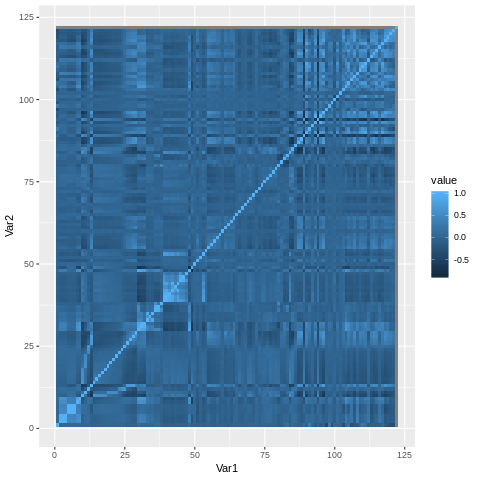

In [31]:
%%R -i tmp1 
cormat <- round(cor(tmp1),2)

library(reshape2)
melted_cormat <- melt(cormat)
head(melted_cormat)

library(ggplot2)
ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()

In [32]:
tmp4 = pd.DataFrame(tmp3, columns=[X_num.columns[i] for i in range(len(X_num.columns)) if sel2.get_support()[i] ] )
tmp4['resp'] = y_train

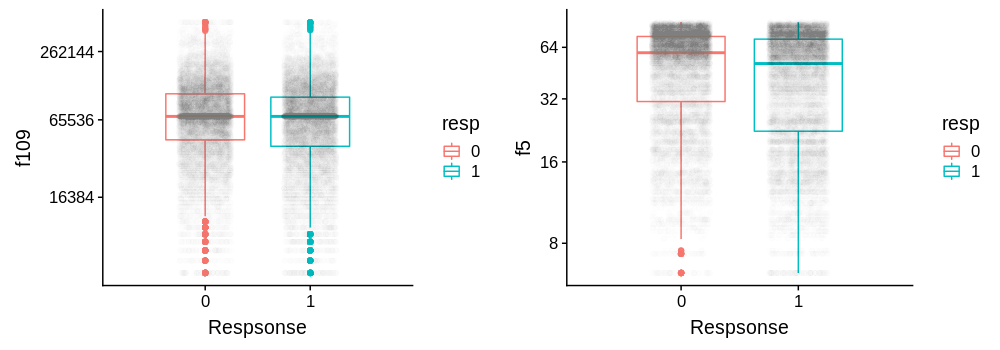

In [33]:
%%R -i tmp4  -w 10 -h 3.5 --units in -r 100 
library(cowplot)
library(scales)  
# box-whiskers plot
tmp4$resp <- factor(tmp4$resp)
library(ggplot2)

p1 <- ggplot(tmp4, aes(resp, f109, colour=resp ))
f109 <- p1 + geom_boxplot(outlier.alpha = 0.25) + geom_jitter(width = 0.25, alpha=.005)  +
    scale_y_continuous(trans=log2_trans()) + coord_trans(y="log2") +
    xlab("Respsonse") + 
    theme(plot.title = element_text(hjust = 0.5))
    
p2 <- ggplot(tmp4, aes(resp, f5, colour=resp ))
f112 <- p2 + geom_boxplot(outlier.alpha = 0.25) + geom_jitter(width = 0.25, alpha=.005)  +
    scale_y_continuous(trans=log2_trans()) + coord_trans(y="log2") +
    xlab("Respsonse") + 
    theme(plot.title = element_text(hjust = 0.5))

# despite being the most dependent on the response, these predictors have large overlap, and do not discriminate much
#TODO: include features with log transformation
plot_grid(f109, f112)

__Feature Selection: Category__
    
We must encode the category variables so that they can be used in numerical algorithms.  Here, we use the features with randomized decision trees (250) to obtain a description of how important each is for discriminating on the response variable.  While each level within a category is used as a tree predictor, we can group the predictors into their original features and see which are the most influential.

The code is taken from the scikit-learn on-line documentation, and is not the authors' own work.

In [34]:
X_cat = X_train.loc[:, X_train.dtypes != np.float64]

In [35]:
from sklearn.preprocessing import OneHotEncoder

imp = SimpleImputer(strategy='constant', fill_value='missing')
tmp1 = imp.fit_transform(X_cat)

enc = OneHotEncoder(handle_unknown='ignore')
tmp2 = enc.fit_transform(tmp1)

In [36]:
#ref: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(tmp2, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [37]:
# Print the feature ranking
print("Feature ranking:")
for f in range(10):  #tmp2.shape[1]
    indices[f]
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) )

Feature ranking:
1. feature 508 (0.010932)
2. feature 529 (0.010168)
3. feature 528 (0.010108)
4. feature 15 (0.009944)
5. feature 515 (0.009791)
6. feature 14 (0.008765)
7. feature 578 (0.008471)
8. feature 550 (0.008283)
9. feature 13 (0.008179)
10. feature 536 (0.007935)


In [38]:
#TODO: sum importance measure for each feature, over all levels, to obtain total feature importance
from collections import Counter

names = enc.get_feature_names()
ohe = list(names[ indices[0:50] ])
grp = [ x.split('_')[0].split('x')[1] for x in ohe]
features = [X_cat.columns[int(x)] for x in grp]
features_cnt = Counter(features)
features_cnt.most_common()

[('f126', 6),
 ('age_bin', 5),
 ('f93', 4),
 ('f3', 3),
 ('f12', 3),
 ('f108', 3),
 ('f13', 2),
 ('f102', 2),
 ('f98', 2),
 ('f96', 2),
 ('f122', 2),
 ('f100', 2),
 ('f120', 2),
 ('f94', 2),
 ('f95', 2),
 ('f115', 1),
 ('f119', 1),
 ('f103', 1),
 ('f97', 1),
 ('f121', 1),
 ('f110', 1),
 ('f99', 1),
 ('f101', 1)]

<br>
<br>

# Pre-processing

Because no features were selected from numeric predictors for removal, and many of the predictors had high correlations among other predictors, Principle Components Analysis (PCA) may be a good method for finding components that explain the greatest amount of variability.  After doing this, we can observe the scree chart of the explained variabilty.  Only the first three components appear strong.  However, we can take more components and allow regularization techniques to remove excess, during modeling.

Typically, PCA (unsupervised selection) should be performed within cross validation _("Elements of Statisical Learning", Hastie,Tibsharani, et al)_ to ensure unbiasedness.  However, we selected a much larger number of numeric predictors than was necessary.  We will allow regularlization to select from among these.  

The numeric data is imputed and centered/scaled before using it with PCA, or a model where optimization is necessary.  The categorical variables are also imputed for missing values, then they are encoded with OneHotEncoder so they can be used as numeric input.

__Numeric Transformations: Dimensionality Reduction with Principle Components Analysis__

In [27]:
N_COMP = 25    # an arbitrary number of components that we can choose after viewing the scree plot

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

col_num = (X_train.loc[:, X_train.dtypes == np.float64]).columns
numeric_features = col_num
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
pca = PCA(n_components=N_COMP)

pipe_num = Pipeline(steps=[
    ('transform', numeric_transformer),
    ('pca', pca) ])
                      
X_num_tng = X_train.loc[:, X_train.dtypes == np.float64]                      
pipe_num.fit(X_num_tng)

Pipeline(memory=None,
     steps=[('transform', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('pca', PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

In [29]:
DF = pd.DataFrame({ 'x' : range(0, len(pca.explained_variance_ratio_), 1),
                   'y' : pca.explained_variance_ratio_})
DF.shape

(25, 2)

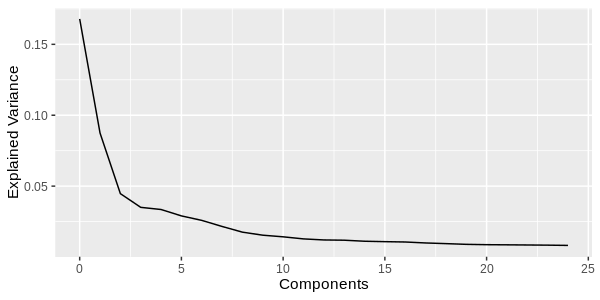

In [30]:
%%R -i DF -w 6 -h 3 --units in -r 100 
library(ggplot2)
ggplot(DF, aes(x=x, y=y)) + geom_line() + 
    xlab("Components") + ylab("Explained Variance")

In [31]:
# top components from numeric features
# more can be removed (if needed) with regularization, during modeling
X_num = X_train.loc[:, X_train.dtypes == np.float64]
X_trans = pipe_num.transform(X_num)
X_trans.shape

(22129, 25)

In [32]:
#prep for pipeline
#columns of numeric features
col_num = (X_train.loc[:, X_train.dtypes == np.float64]).columns

#numeric: use pipe_num from earlier
numeric_features = col_num

__Categorical Transformations__

In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

#columns of category features
col_cat = (X_train.loc[:, X_train.dtypes != np.float64]).columns

#categoric
categorical_features = col_cat
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

__Pipeline Creation__

In [34]:
#transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', pipe_num, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

<br>
<br>

# Classification Models

We will train, evaluate, and compare three different classifiers: K-Nearest Neighbors, Logistic Regression, and Decision Tree.  The modeling approaches are quite different, which will provide diversity in performance.  If time allows, an ensemble of the three will be trained using VotingClassifier().

__Configure__

In [35]:
#! ls Data/survey/
#! mkdir Data/survey/Models

In [36]:
from sklearn.externals import joblib
import os

cwd = os.getcwd()
file_path = cwd+'/Data/survey/Models/'

# save the model to disk
filename = file_path+'finalized_model.sav'
#joblib.dump(model, filename)
 
# some time later...
# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

__Model: K-nearest Neighbors__

In [37]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=5)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('knn', knn)])
param_grid = {"knn__n_neighbors": [3, 5, 7]}
knn_gs = RandomizedSearchCV(pipe, param_grid, iid=True, cv=5, scoring="accuracy", n_iter=20)

In [38]:
knn_gs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('transform', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, mis...owski',
           metric_params=None, n_jobs=5, n_neighbors=5, p=2,
           weights='uniform'))]),
          fit_params=None, iid=True, n_iter=20, n_jobs=None,
          param_distributions={'knn__n_neighbors': [3, 5, 7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [39]:
# Cross Validation

knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % knn_gs.best_score_)

{'knn__n_neighbors': 3}
Best parameter (CV score=0.665):


In [47]:
(pd.DataFrame(knn_gs.cv_results_)).transpose()

,0,1,2
mean_fit_time,0.824303,0.831277,0.838233
std_fit_time,0.066148,0.0992712,0.0659644
mean_score_time,12.2414,12.5471,12.3765
std_score_time,0.162748,0.310413,0.190593
param_knn__n_neighbors,3,5,7
params,{'knn__n_neighbors': 3},{'knn__n_neighbors': 5},{'knn__n_neighbors': 7}
split0_test_score,0.660041,0.624125,0.623673
split1_test_score,0.666968,0.632851,0.613421
split2_test_score,0.661545,0.624266,0.612291
split3_test_score,0.676158,0.643842,0.624181


In [40]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

y_train_pred = knn_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[ 8611,  2510],
       [  816, 10192]])

In [41]:
y_pred = knn_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[1633, 1077],
       [ 637, 2186]])

In [42]:
# Testing

from sklearn.metrics import accuracy_score

# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.690
Precision score: 0.670
Recall score: 0.774
F1 score: 0.718


In [43]:
# Testing

#predictions for outcome labels
#Predict class probabilities for X.  The predicted class probabilities of an input sample are computed as the mean predicted
#class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same
#class in a leaf.
y_class_prob = knn_gs.predict_proba(X_test)                 # called   predict_proba(), for some classifiers
y_prob = np.asarray( [x[1] for x in y_class_prob], dtype=np.float32)
threshold = 0                                               # set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: 0.566
Area Under ROC Curve: 0.748


In [77]:
# save model
filename = file_path+'knn_gs_model.sav'
joblib.dump(knn_gs, filename)

['/home/jovyan/work/notebooks/IMTorgDemo-Notebooks/Data/survey/Models/knn_gs_model.sav']

__Model: Logistic Regression__

In [57]:
#ref: SGD classifier will have the same loss function as the Logistic Regression but a different solver
from sklearn.linear_model import SGDClassifier

logistic = SGDClassifier(loss='log', penalty='l1', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('logistic', logistic)
])

param_grid = {
    'logistic__alpha': np.logspace(-4, 4, 5),
}
log_gs = GridSearchCV(pipe, param_grid, iid=True, cv=10, return_train_score=False)
log_gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('transform', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, mis...dom_state=0, shuffle=True, tol=1e-05,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'logistic__alpha': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [58]:
# Cross Validation

log_best = log_gs.best_estimator_
print(log_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % log_gs.best_score_)

{'logistic__alpha': 0.01}
Best parameter (CV score=0.594):


In [59]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
y_train_pred = log_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[6754, 4298],
       [4655, 6422]])

In [60]:
y_pred = log_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[1683, 1096],
       [1115, 1639]])

In [61]:
# Test

from sklearn.metrics import accuracy_score

y_pred = log_gs.predict(X_test)
# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.600
Precision score: 0.599
Recall score: 0.595
F1 score: 0.597


In [62]:
# Test

#predictions for outcome labels
#decision_function: Predict confidence scores for samples.  The confidence score for a sample is the signed distance of that
#sample to the hyperplane.
y_prob = log_gs.decision_function(X_test)		        # called   predict_proba(), for some classifiers
threshold = 0											# set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: 0.021
Area Under ROC Curve: 0.629


In [63]:
#save model
filename = file_path+'log_gs_model.sav'
joblib.dump(log_gs, filename)

['/home/jovyan/work/notebooks/IMTorgDemo-Notebooks/Data/survey/Models/log_gs_model.sav']

__Model: Random Forest__

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rf', rf)
])

param_grid = {'rf__n_estimators': [10, 50, 100], 'rf__max_depth':np.arange(2, 8)}
rf_gs = GridSearchCV(pipe, param_grid, iid=True, cv=10, return_train_score=False)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('transform', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, mis...ors='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=None,
       param_grid={'rf__n_estimators': [10, 50, 100], 'rf__max_depth': array([2, 3, 4, 5, 6, 7])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=0)

In [65]:
# Cross Validation

rf_best = rf_gs.best_estimator_
print(rf_gs.best_params_)
#GridSearchCV: Mean cross-validated score of the best_estimator
#SGDClassifier: Returns the mean accuracy on the given test data and labels
print("Best parameter (CV score=%0.3f):" % rf_gs.best_score_)

{'rf__max_depth': 7, 'rf__n_estimators': 100}
Best parameter (CV score=0.622):


In [68]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
y_train_pred = rf_gs.predict(X_train)
print( "Confusion matrix: Training")
confusion_matrix(y_train, y_train_pred)

Confusion matrix: Training


array([[6985, 4067],
       [3696, 7381]])

In [69]:
y_pred = rf_gs.predict(X_test)
print( "Confusion matrix: Testing")
confusion_matrix(y_test, y_pred)

Confusion matrix: Testing


array([[1718, 1061],
       [ 983, 1771]])

In [70]:
# Testing

from sklearn.metrics import accuracy_score

y_pred = rf_gs.predict(X_test)
# fraction of correctly classified samples
print( "Accuracy score: %0.3f" % accuracy_score(y_test, y_pred) )

from sklearn.metrics import precision_score, recall_score
print( "Precision score: %0.3f" % precision_score(y_test, y_pred) )             # TP / (TP+FP)
print( "Recall score: %0.3f" % recall_score(y_test, y_pred)   )                 # TP / (TP+FN)

from sklearn.metrics import f1_score
print( "F1 score: %0.3f" % f1_score(y_test, y_pred) )

Accuracy score: 0.631
Precision score: 0.625
Recall score: 0.643
F1 score: 0.634


In [71]:
# Testing

#predictions for outcome labels
#Predict class probabilities for X.  The predicted class probabilities of an input sample are computed as the mean predicted
#class probabilities of the trees in the forest. The class probability of a single tree is the fraction of samples of the same
#class in a leaf.
y_class_prob = rf_gs.predict_proba(X_test)                  # called   predict_proba(), for some classifiers
y_prob = np.asarray( [x[1] for x in y_class_prob], dtype=np.float32)
threshold = 0                                               # set threshold
y_some_digit_pred = (y_prob > threshold)
print( "Average training probability: %0.3f" % np.mean(y_prob) )

#roc auc
from sklearn.metrics import roc_auc_score
print( "Area Under ROC Curve: %0.3f" % roc_auc_score(y_test, y_prob) )

Average training probability: 0.501
Area Under ROC Curve: 0.673


In [72]:
filename = file_path+'rf_gs_model.sav'
joblib.dump(rf_gs, filename)

['/home/jovyan/work/notebooks/IMTorgDemo-Notebooks/Data/survey/Models/rf_gs_model.sav']

<br>
<br>

# Comparison Evaluation

In [75]:
knn_y_class_prob = knn_gs.predict_proba(X_test)
log_y_prob = log_gs.decision_function(X_test) 
rf_y_class_prob = rf_gs.predict_proba(X_test)

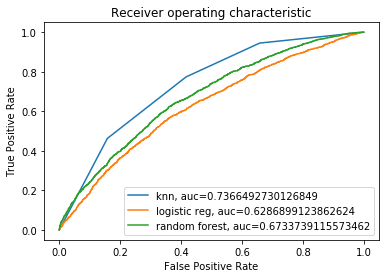

In [76]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

#KNN
y_prob = np.asarray( [x[1] for x in knn_y_class_prob], dtype=np.float32)
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="knn, auc="+str(auc))

#LogisticRegression  
y_prob = log_y_prob
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="logistic reg, auc="+str(auc))

#RandomForest   
y_prob = np.asarray( [x[1] for x in rf_y_class_prob], dtype=np.float32)
fpr, tpr, thresh = metrics.roc_curve(y_test, y_prob)
auc = metrics.roc_auc_score(y_test, y_prob)
plt.plot(fpr,tpr,label="random forest, auc="+str(auc))


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=0)

In [ ]:
#Thank you, and good night!